# State Farm - Distracted Driver Challenge

According to the CDC motor vehicle safety division, one in five car accidents is caused by a distracted driver. The aim of the Kaggle competition launched by State Farm is to assess if computer vision can spot distracted drivers. 

State Farm placed dashboard cameras in the cars of a sample of drivers and provided a dataset of 2D dashboard camera images in which the drivers are engaging in a range of activities (texting, eating, talking on the phone, makeup, reaching behind, etc). The goal is to predict the likelihood of what the driver is doing in each picture. 

The 10 classes to predict are:
* c0: safe driving
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger

## Loading Libraries

In [65]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from scipy.misc import toimage
import pylab as pl
import numpy as np
from numpy import ma as ma
import os
import collections
import glob
import datetime
import pandas as pd
import cv2
import math
import pickle
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras import backend as K
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

## Loading Images 

In [3]:
def get_im(path):
    # Load as grayscale
    img = cv2.imread(path, 0)
    # Reduce size to 128 x 96
    resized = cv2.resize(img, (128, 96))
    return resized

### Training Set

The original training set consists of 22,424 images.

In [4]:
def load_train():
    X_train = []
    y_train = []
    print('Read train images')
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join('imgs', 'train', 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            img = get_im(fl)
            X_train.append(img)
            y_train.append(j)

    return X_train, y_train

In [5]:
train_data, train_target = load_train()

Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9


In [6]:
# # to see 1 image, click + 0 to kill window
# cv2.startWindowThread()
# cv2.imshow('image',train_data[1])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

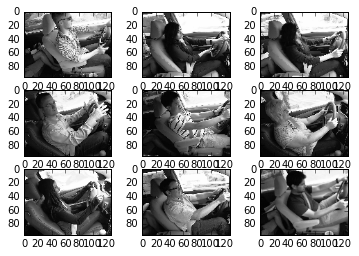

In [7]:
# create a grid of 3x3 images
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(toimage(train_data[i]),cmap='Greys_r')
# show the plot
plt.show()

In [8]:
print(train_data[1])

[[ 41  42  41 ..., 253 254 254]
 [ 42  39  43 ..., 245 254 254]
 [ 43  43  44 ..., 222 235 248]
 ..., 
 [ 38  39  37 ...,   9  12   7]
 [ 24  18  16 ...,   8   8  84]
 [ 56  56  60 ...,   9  10  97]]


In [9]:
print(train_target[1])

0


In [10]:
print(len(train_target))

22424


In [11]:
print(collections.Counter(train_target))

Counter({0: 2489, 3: 2346, 4: 2326, 6: 2325, 2: 2317, 5: 2312, 1: 2267, 9: 2129, 7: 2002, 8: 1911})


### Test Set 

The test set of images that need to be classified consists of 79,726 images.

In [12]:
def load_test():
    print('Read test images')
    path = os.path.join('imgs', 'test', '*.jpg')
    files = glob.glob(path)
    X_test = []
    X_test_id = []
    total = 0
    thr = math.floor(len(files)/10)
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im(fl)
        X_test.append(img)
        X_test_id.append(flbase)
        total += 1
        if total%thr == 0:
            print('Read {} images from {}'.format(total, len(files)))

    return X_test, X_test_id

In [13]:
test_data, test_id = load_test()

Read test images
Read 7972 images from 79726
Read 15944 images from 79726
Read 23916 images from 79726
Read 31888 images from 79726
Read 39860 images from 79726
Read 47832 images from 79726
Read 55804 images from 79726
Read 63776 images from 79726
Read 71748 images from 79726
Read 79720 images from 79726


In [14]:
print(len(test_id))

79726


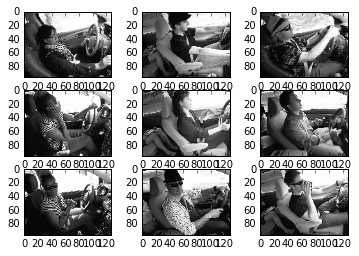

In [15]:
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(toimage(test_data[i]),cmap='Greys_r')
# show the plot
plt.show()

## Formatting Data 

In [16]:
# image classes
nb_classes = 10
# input image dimensions
img_rows, img_cols = 96, 128
# color type: 1 - grey, 3 - rgb
color_type = 1

In [17]:
train_data = np.array(train_data, dtype=np.uint8)
train_target = np.array(train_target, dtype=np.uint8)
train_data = train_data.reshape(train_data.shape[0], 1, img_rows, img_cols)

# use a one hot encoding to transform output variables into a binary matrix
train_target = np_utils.to_categorical(train_target, nb_classes)
print(train_target.shape[1])

# normalize inputs from 0-255 to 0.0-1.0 
# as pixel values are in the range of 0 to 255 for each of the red, green and blue channels.
train_data = train_data.astype('float32')
train_data /= 255

print('Train shape:', train_data.shape)
print(train_data.shape[0], 'train samples')

10
('Train shape:', (22424, 1, 96, 128))
(22424, 'train samples')


In [18]:
print(train_data[[1]])

[[[[ 0.16078432  0.16470589  0.16078432 ...,  0.99215686  0.99607843
     0.99607843]
   [ 0.16470589  0.15294118  0.16862746 ...,  0.96078432  0.99607843
     0.99607843]
   [ 0.16862746  0.16862746  0.17254902 ...,  0.87058824  0.92156863
     0.97254902]
   ..., 
   [ 0.14901961  0.15294118  0.14509805 ...,  0.03529412  0.04705882
     0.02745098]
   [ 0.09411765  0.07058824  0.0627451  ...,  0.03137255  0.03137255
     0.32941177]
   [ 0.21960784  0.21960784  0.23529412 ...,  0.03529412  0.03921569
     0.38039216]]]]


In [19]:
print(train_target)

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


In [20]:
test_data = np.array(test_data, dtype=np.uint8)
test_data = test_data.reshape(test_data.shape[0], 1, img_rows, img_cols)

test_data = test_data.astype('float32')
test_data /= 255
print('Test shape:', test_data.shape)
print(test_data.shape[0], 'test samples')

('Test shape:', (79726, 1, 96, 128))
(79726, 'test samples')


## Splitting Training Data into Training, Validation and Holdout Datasets

The original training set contained 22,424 images. This dataset is split between a training, a validation and a holdout sets. The validation (test) set consists of 20% of the original training set and the holdout set of 20% of the remaining set. 

In [21]:
def split_validation_set_with_hold_out(train, target, test_size):
    random_state = 51
    train, X_test, target, y_test = train_test_split(train, target, test_size=test_size, random_state=random_state)
    X_train, X_holdout, y_train, y_holdout = train_test_split(train, target, test_size=test_size, random_state=random_state)
    return X_train, X_test, X_holdout, y_train, y_test, y_holdout

In [22]:
X_train, X_test, X_holdout, Y_train, Y_test, Y_holdout = split_validation_set_with_hold_out(train_data, train_target, 0.2)
print('Split train: ', len(X_train))
print('Split valid: ', len(X_test))
print('Split holdout: ', len(X_holdout))

('Split train: ', 14351)
('Split valid: ', 4485)
('Split holdout: ', 3588)


## Setting Up the Model

### Parameters

* **Batch Size:** batch size to split data to train network, it corresponds to the number of training examples in one forward/ backward pass. As computing the gradient over the entire dataset is expensive, a sample of training examples will be used for each iteration. The higher the batch size, the more memory space you'll need.
* **Epoch:** Number of one forward and one backward pass of all the training examples, the number of times the algorithm sees the entire data set. In our case as we have 14351 examples and we use a batch size of 64, so it will take 224 iterations to complete 1 epoch.
* **Filters:** number of convolutional filters to use (depth), each learning to look for something different in the input.
* **Convolutional Kernel Size:** Number of rows and columns.
* **Pooling:** Size of pooling area for max pooling.

In [23]:
# BATCH SIZE
batch_size = 64

# EPOCH
nb_epoch = 10

# FILTERS
nb_filters = 32 

# CONVOLUTIONAL KERNEL SIZE 
nb_conv = 3

# POOLING
nb_pool = 2

### Initialising the Sequential Model
In this report we are using Keras with a Theano backend. Keras is a minimalist, highly modular neural networks library, written in Python and capable of running on top of either TensorFlow or Theano. Theano is a Python library that lets you to define, optimize, and evaluate mathematical expressions, especially ones with multi-dimensional arrays. Keras was developed with a focus on enabling fast experimentation. The core data structure of Keras is a model, a way to organize layers. The main type of model is the Sequential model, a linear stack of layers.

In [24]:
model = Sequential()

### Convolutional Layer
It forms the basis of the CNN and performs the core operations of training and consequently firing the neurons of the network. It performs the convolution operation over the input volume and consists of a 3-dimensional arrangement of neurons (a stack of 2-dimensional layers of neurons, one for each channel depth).

* **Relu**: Rectified Linear Unit activation function. Every activation function (or non-linearity) takes a single number and performs a certain fixed mathematical operation on it. It computes the function f(x)=max(0,x). In other words, the activation is simply thresholded at zero. It greatly accelerates the convergence of stochastic gradient descent and can be implemented by simply thresholding a matrix of activations at zero but ReLU units can irreversibly die during training since they can get knocked off the data manifold (Leaky ReLUs are one attempt to fix the “dying ReLU” problem). ReLU is also only used for hidden layers.

* **W Constraint**: max norm regularization to avoid overfitting. It enforces an absolute upper bound on the magnitude of the weight vector for every neuron and use projected gradient descent to enforce the constraint. In practice, this corresponds to performing the parameter update as normal, and then enforcing the constraint by clamping the weight vector of every neuron. 

* **Border mode**: With border mode "same" you get an output that is the "same" size as the input. That means that the filter has to go outside the bounds of the input by filter size / 2 - the area outside of the input is normally padded with zeros.

In [25]:
# Convolutional input layer, 32 feature maps with a size of 3×3, a rectifier activation function and a weight constraint of max norm set to 3
model.add(Convolution2D(nb_filters, nb_conv, nb_conv, input_shape=(color_type, img_rows, img_cols), border_mode='same', W_constraint=maxnorm(3)))
convout1 = Activation('relu')
model.add(convout1)

### Dropout 
    
Dropout consists in randomly setting a fraction p of input units to 0 at each update during training time, which helps prevent overfitting. Applying dropout to a neural network amounts to sampling a “thinned” network from it. The thinned network consists of all the units that survived the dropout. 

In [26]:
# Dropout set to 20%
model.add(Dropout(0.2))

### Convolutional Layer 2

In [27]:
# Convolutional layer, 32 feature maps with a size of 3×3, a rectifier activation function and a weight constraint of max norm set to 3
model.add(Convolution2D(nb_filters, nb_conv, nb_conv, border_mode='same', W_constraint=maxnorm(3)))
convout2 = Activation('relu')
model.add(convout2)

### Pooling Layer

Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting. The Pooling Layer operates independently on every depth slice of the input and resizes it spatially, using the MAX operation. (2, 2) will halve the image in each dimension.

In [28]:
# Max Pool layer with size 2×2
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

In [29]:
# Flatten the data for the 1D layers
model.add(Flatten())

### Fully Connected Layer

Neurons in a fully connected layer have full connections to all activations in the previous layer

In [30]:
# Fully connected layer with 512 units and a rectifier activation function 
# Not sure why the value was set to 512 - x32 like 512, 1024 and 2048 seem like popular default values and might be related to GPU architectures
model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))

### Dropout 2

In [31]:
# Dropout set to 50%
model.add(Dropout(0.5))

### Output Layer

* **Softmax Activation**: This activation function is used in the output layer for classification because it provides probabilities for different classes, each neuron's activation value is interpreted as a probability value.

In [32]:
# Fully connected output layer with 10 units and a softmax activation function
model.add(Dense(nb_classes, activation='softmax'))

## Configuring the Learning Process

* **Gradient Descent**: What we'd like is an algorithm which lets us find weights and biases so that the output from the network approximates y(x) for all training inputs x. We'll call C the quadratic cost function; it's also sometimes known as the mean squared error or just MSE. We want a move that is a small step of a fixed size, and we're trying to find the movement direction which decreases C as much as possible. So gradient descent can be viewed as a way of taking small steps in the direction which does the most to immediately decrease C.

* **Learning Rate**: The learning rate is a parameter that determines how much an updating step influences the current value of the weights. 

* **Decay**: In training deep networks, it is usually helpful to anneal the learning rate over time. Good intuition to have in mind is that with a high learning rate, the system contains too much kinetic energy and the parameter vector bounces around chaotically, unable to settle down into deeper, but narrower parts of the loss function. Knowing when to decay the learning rate can be tricky: Decay it slowly and you’ll be wasting computation bouncing around chaotically with little improvement for a long time. But decay it too aggressively and the system will cool too quickly, unable to reach the best position it can. In this case we are using 1/t decay.

* **Momentum**: Momentum simply adds a fraction m of the previous weight update to the current one. When the gradient keeps pointing in the same direction, this will increase the size of the steps taken towards the minimum. It is otherefore often necessary to reduce the global learning rate when using a lot of momentum (m close to 1). If you combine a high learning rate with a lot of momentum, you will rush past the minimum with huge steps!

In [33]:
# A logarithmic loss function is used with the stochastic gradient descent (SGD) optimization algorithm configured 
# with a large momentum and weight decay start with a learning rate of 0.01
lrate = 0.01
decay = lrate/nb_epoch
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

* **Cross Entropy**: A cost function, the cross-entropy is positive, and tends toward zero as the neuron gets better at computing the desired output for all training inputs. But the cross-entropy cost function has the benefit that, unlike the quadratic cost, it avoids the problem of learning slowing down. The rate at which the weight learns is controlled by the error in the output. The larger the error, the faster the neuron will learn. 

In [34]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [35]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 96, 128)   320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 96, 128)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 96, 128)   0           activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 96, 128)   9248        dropout_1[0][0]                  
___________________________________________________________________________________________

## Training the Model

In [36]:
history = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
               verbose=1, validation_data=(X_test, Y_test))

Train on 14351 samples, validate on 4485 samples
Epoch 1/10
14351/14351 [==============================] - 895s - loss: 1.9349 - acc: 0.2927 - val_loss: 1.3170 - val_acc: 0.6609
Epoch 2/10
14351/14351 [==============================] - 848s - loss: 0.9435 - acc: 0.6739 - val_loss: 0.3411 - val_acc: 0.9226
Epoch 3/10
14351/14351 [==============================] - 864s - loss: 0.3902 - acc: 0.8693 - val_loss: 0.1086 - val_acc: 0.9753
Epoch 4/10
14351/14351 [==============================] - 970s - loss: 0.2033 - acc: 0.9335 - val_loss: 0.0793 - val_acc: 0.9806
Epoch 5/10
14351/14351 [==============================] - 1040s - loss: 0.1198 - acc: 0.9615 - val_loss: 0.0439 - val_acc: 0.9884
Epoch 6/10
14351/14351 [==============================] - 1111s - loss: 0.0762 - acc: 0.9760 - val_loss: 0.0431 - val_acc: 0.9893
Epoch 7/10
14351/14351 [==============================] - 1104s - loss: 0.0701 - acc: 0.9767 - val_loss: 0.0355 - val_acc: 0.9891
Epoch 8/10
14351/14351 [=====================

## Evaluating the Model 

With each epoch the loss on the training and the validation sets is decreasing and the accuracy increasing as the model is learning. The final accuracy on the validation dataset is 99.15% (with a loss of 0.03) and 99.39% on the holdout dataset (with a loss of 0.02). 

It is interesting to see that the accuracy is higher on the validation set than on the training set. This might happen because the validation set used is quite small and the model is still underfitting; the gap is becoming smaller with each epoch and might go away if we trained the model for longer. 

In [40]:
print("Metrics: ", model.metrics_names)

score = model.evaluate(X_test, Y_test, verbose=0)
print("Score: ", score)
print("Accuracy: %.2f%%" % (score[1]*100))

scoreh = model.evaluate(X_holdout, Y_holdout, verbose=0)
print("Score holdout: ", scoreh)
print("Accuracy holdout: %.2f%%" % (scoreh[1]*100))

('Metrics: ', ['loss', 'acc'])
('Score: ', [0.032516949830595769, 0.99152731326644372])
Accuracy: 99.15%
('Score holdout: ', [0.023120666545492087, 0.99386845039018956])
Accuracy holdout: 99.39%


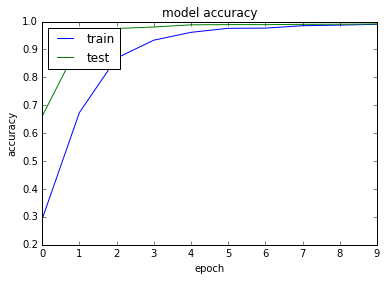

In [38]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

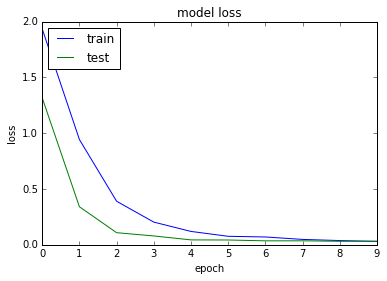

In [39]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predicting on New Data

We can now use the model to predict the classes of the images contained in the original test dataset.

In [43]:
predictions = model.predict(test_data, batch_size=128, verbose=1)

79726/79726 [==============================] - 1406s  


In [44]:
print(predictions)

[[  1.89304722e-13   7.69701577e-21   1.24762659e-10 ...,   6.48552670e-11
    4.17617260e-11   6.06750632e-07]
 [  2.38357711e-06   2.03371783e-07   2.33146475e-05 ...,   7.64645574e-06
    8.61848036e-07   3.17002076e-07]
 [  8.22021044e-04   9.58803117e-01   4.18555574e-04 ...,   4.56221495e-03
    5.64595684e-04   4.38168121e-04]
 ..., 
 [  9.59600802e-05   1.83640182e-01   2.28791349e-02 ...,   7.77343452e-01
    8.96269805e-04   2.18868791e-03]
 [  9.85687296e-11   3.17573828e-10   9.74693103e-06 ...,   4.54358553e-04
    8.78842475e-05   5.99912298e-08]
 [  7.99246613e-10   1.16309884e-09   2.83781992e-06 ...,   4.07926473e-06
    4.20784857e-03   3.51404378e-05]]


In [45]:
def create_submission(predictions, test_id, loss):
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.loc[:, 'img'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = str(round(loss, 6)) + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)

In [46]:
create_submission(predictions, test_id, score[0])

## Convolution Visualizations

### Convolution 1

In [52]:
inputs = [K.learning_phase()] + model.inputs

_convout1_f = K.function(inputs, [convout1.output])
def convout1_f(X):
    # The [0] is to disable the training phase flag
    return _convout1_f([0] + [X])

In [53]:
def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)

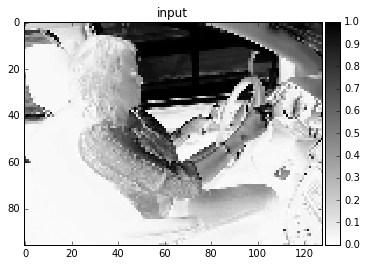

In [58]:
i = 4600

# Visualize the first layer of convolutions on an input image
X = test_data[i:i+1]

pl.figure()
pl.title('input')
nice_imshow(pl.gca(), np.squeeze(X), vmin=0, vmax=1, cmap=cm.binary)

In [59]:
def make_mosaic(imgs, nrows, ncols, border=1):
    
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic


('W shape : ', (32, 3, 3))


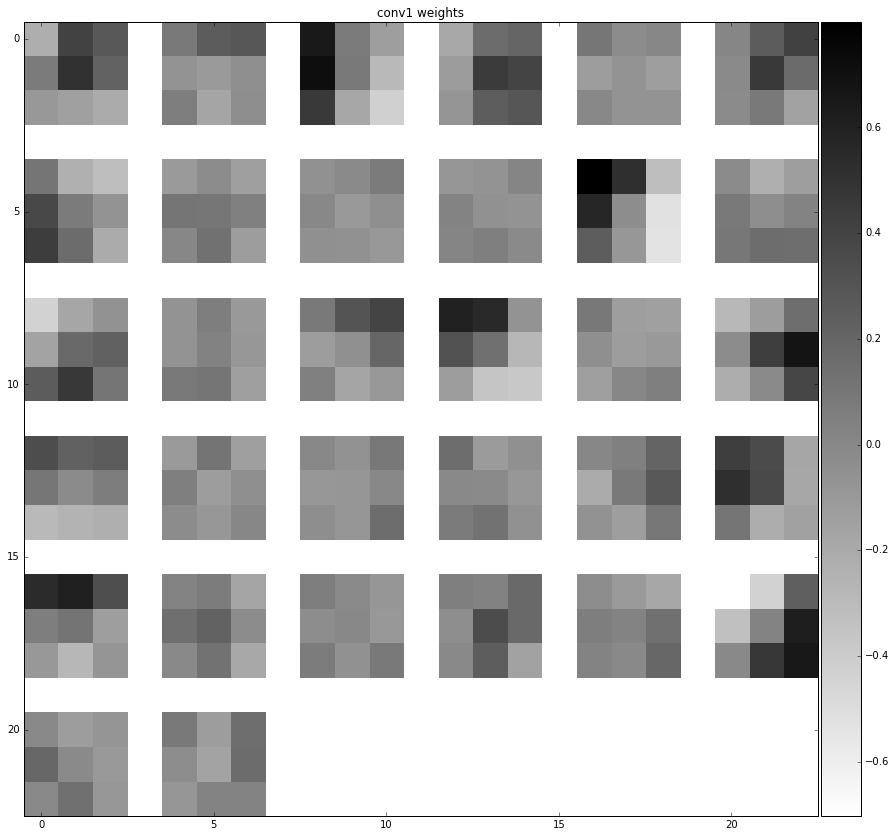

In [60]:
# Visualize weights for each of the 32 filters, displays what sort of input maximizes each filter in each layer
W = model.layers[0].W.get_value(borrow=True)
W = np.squeeze(W)
print("W shape : ", W.shape)

pl.figure(figsize=(15, 15))
pl.title('conv1 weights')
nice_imshow(pl.gca(), make_mosaic(W, 6, 6), cmap=cm.binary)

('C1 shape : ', (32, 96, 128))


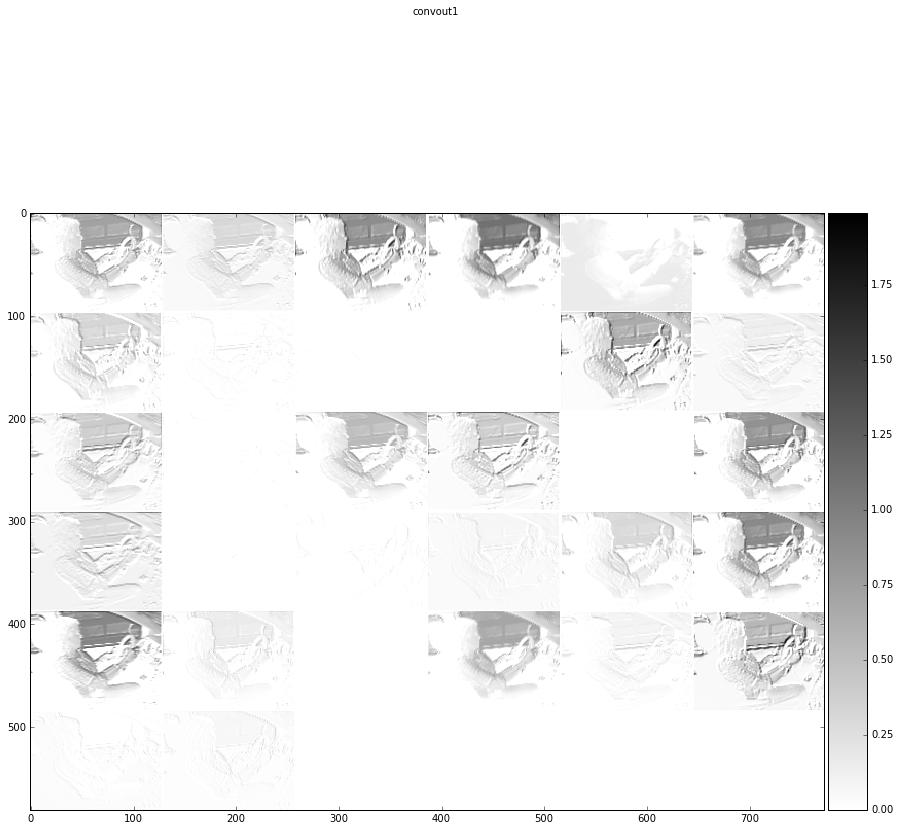

In [61]:
# Visualize convolution result (after activation)
C1 = convout1_f(X)
C1 = np.squeeze(C1)
print("C1 shape : ", C1.shape)

pl.figure(figsize=(15, 15))
pl.suptitle('convout1')
nice_imshow(pl.gca(), make_mosaic(C1, 6, 6), cmap=cm.binary)

### Convolution 2

In [62]:
_convout2_f = K.function(inputs, [convout2.output])
def convout2_f(X):
    # The [0] is to disable the training phase flag
    return _convout2_f([0] + [X])

('C2 shape : ', (32, 96, 128))


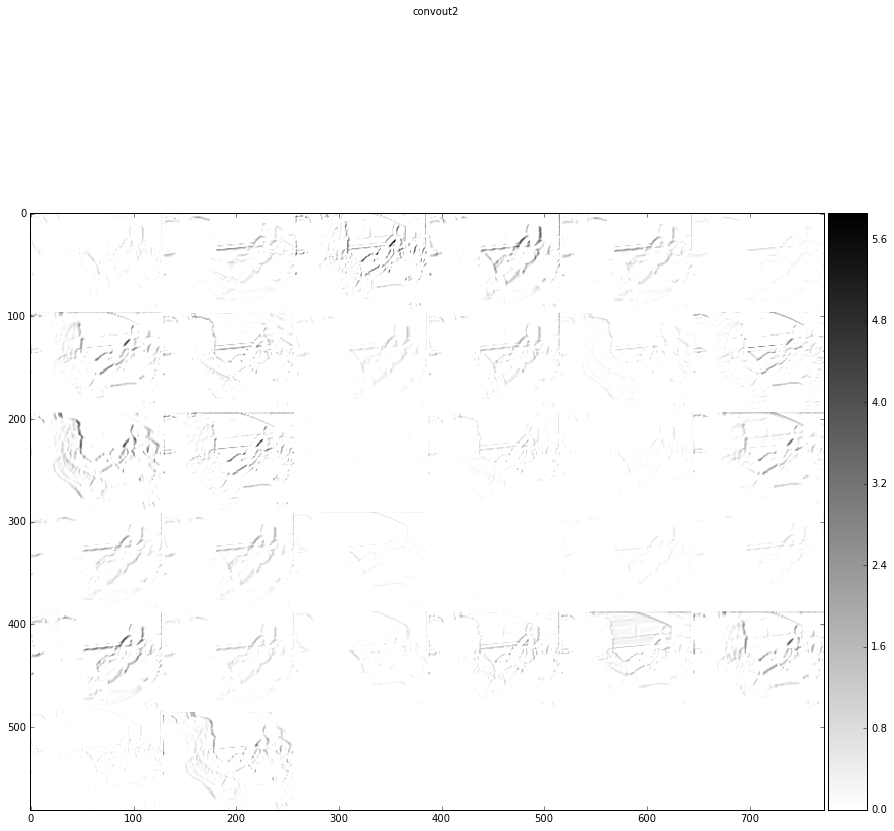

In [63]:
# Visualize convolution result (after activation)
C2 = convout2_f(X)
C2 = np.squeeze(C2)
print("C2 shape : ", C2.shape)

pl.figure(figsize=(15, 15))
pl.suptitle('convout2')
nice_imshow(pl.gca(), make_mosaic(C2, 6, 6), cmap=cm.binary)

## Sources

* https://www.kaggle.com/c/state-farm-distracted-driver-detection
* http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/
* http://cs231n.github.io/
* http://neuralnetworksanddeeplearning.com/
* https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html